In [1]:
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import matplotlib.ticker as ticker
import numpy as np
import os
import progressbar
import random
import time

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data

In [2]:
MAX_LENGTH = 50

class EncoderRNN(nn.Module): 
    def __init__(self, input_size, hidden_size, positional, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p

        self.positional = positional
        self.word_embedding = nn.Embedding(input_size, hidden_size)
        self.pos_embedding = nn.Embedding(input_size, hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.linear = nn.Linear(hidden_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        word_embedded = self.word_embedding(input).view(1, 1, -1)
        
        if self.positional:
            pos_embedded = self.pos_embedding(input).view(1, 1, -1)
            output = self.dropout(word_embedded + pos_embedded)
            output = self.linear(output)
            hidden = self.linear(hidden)
        else:
            output, hidden = self.gru(word_embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)
    
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [3]:
def read_data(file_name):
    """
    Reads the data and returns it in a list.
    """
    
    f = open(file_name, "r")
    return [line.strip().split() for line in f.readlines()]


def word_to_index(file_name):
    """
    Obtains the vocabulary of a file and returns it 
    in a dictionary to be able to use w2i.
    """
    
    file = open(file_name) 
    w2i = json.load(file)
    w2i["<sos>"] = len(w2i)
    return w2i


def index_to_word(dictionary):
    """
    Reverses the dictionary such that i2w can be used.
    """
    
    reversed_dict = {}
    
    for word, index in dictionary.items():
        reversed_dict[index] = word
    reversed_dict[index + 1] = "<sos>" 
    return reversed_dict


def sentence_to_indices(w2i, sentence):
    """
    Returns the indices of the words in a sentence in a list.
    """
    
    return [w2i[word] for word in sentence]


def sentence_to_tensor(w2i, sentence):
    """
    Returns the tensor of a sentence.
    """
    
    indices = sentence_to_indices(w2i, sentence)
    indices.append(EOS_token)
    return torch.tensor(indices, dtype=torch.long).view(-1, 1)

train_english = read_data("data/train_preprocessed.en")
train_french = read_data("data/train_preprocessed.fr")

val_english = read_data("data/val_preprocessed.en")
val_french = read_data("data/val_preprocessed.fr")

w2i_french = word_to_index("data/train_preprocessed.fr.json")
w2i_english = word_to_index("data/train_preprocessed.en.json")

i2w_french = index_to_word(w2i_french)
i2w_english = index_to_word(w2i_english)

EOS_token = w2i_english["<eos>"]
SOS_token = w2i_english["<sos>"]

teacher_forcing_ratio = 0.5
positional = True

  0% (1 of 5000) |                        | Elapsed Time: 0:00:00 ETA:  0:14:58

Iteration 1 of 1


100% (5000 of 5000) |#####################| Elapsed Time: 0:07:32 Time: 0:07:32


loss: 18151.190694768193


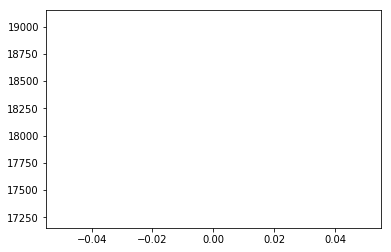

In [5]:
def showPlot(points):
    plt.figure()
#     fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
#     loc = ticker.MultipleLocator(base=0.2)
#     ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))    


def train(input_sentence, target_sentence, w2i_english, 
          w2i_french, encoder, decoder, encoder_optimizer, 
          decoder_optimizer, criterion, max_length=MAX_LENGTH):
    """
    Does one iteration of training.
    """
    
    loss = 0     
    output_sentence = []
    input_tensor = sentence_to_tensor(w2i_english, input_sentence)
    target_tensor = sentence_to_tensor(w2i_french, target_sentence)

    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

    if input_length > MAX_LENGTH: input_length = MAX_LENGTH
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]])
    decoder_hidden = encoder_hidden
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break         
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.item()/target_length


def train_dataset(w2i_english, w2i_french, train_english, 
                  train_french, encoder, decoder, learning_rate):
    """
    Trains the Encoder-Decoder model for the entire data set.
    """
    
    start = time.time()

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    total_loss = 0

#     with progressbar.ProgressBar(max_value=len(train_english)) as bar:
    with progressbar.ProgressBar(max_value=5000) as bar:
#         for iter in range(1, len(train_english) + 1):
        for iter in range(1, 5000+1):
            input_sentence = train_english[iter-1]
            target_sentence = train_french[iter-1]
            loss = train(input_sentence, target_sentence, w2i_english, 
                         w2i_french, encoder, decoder, encoder_optimizer, 
                         decoder_optimizer, criterion)
            total_loss += loss
            bar.update(iter-1)
    return total_loss


def train_epochs(w2i_english, w2i_french, train_english, train_french,
                encoder, decoder, num_epochs, learning_rate=0.01):
    """
    Trains the Encoder-Decoder for a certain amount of epochs.
    """
    
    losses = []
    
    for iter in range(1, num_epochs + 1):
        print("Iteration", iter, "of", num_epochs)
        loss = train_dataset(w2i_english, w2i_french,
                             train_english, train_french, 
                             encoder, decoder, learning_rate)
        print("loss:", loss)
        losses.append(loss)
    showPlot(losses)
    
encoder = EncoderRNN(len(i2w_english), 256, positional)
decoder = AttnDecoderRNN(256, len(i2w_french))
train_epochs(w2i_english, w2i_french, train_english, train_french,
             encoder, decoder, 1)

In [11]:
def evaluate(encoder, decoder, w2i_english, i2w_french,
             sentence, max_length=MAX_LENGTH):
    """
    Evaluates a sentence.
    """
    
    with torch.no_grad():
        input_tensor = sentence_to_tensor(w2i_english, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

        if input_length > MAX_LENGTH: input_length = MAX_LENGTH
        
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]])  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append("<eos>")
                break
            else:
                decoded_words.append(i2w_french[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]
    
    
def evaluate_dataset(encoder, decoder, val_english):
    """
    Evaluates the entire validation set.
    """
    
    predictions = []
    
    for sentence in val_english:
        predicted_words, attentions = evaluate(encoder, decoder, w2i_english, i2w_french, sentence)
        del predicted_words[-1]
        predicted_sentence = ' '.join(predicted_words)
        predictions.append(predicted_sentence)
    return predictions
        

def save_predictions(predictions, file_name):
    """
    Saves the encoded predicted sentences decoded to a file.
    """
    
    with open("temp_encoded.txt", "w") as f:
        for sentence in predictions:
            f.write(sentence + "\n")
    f.close()
    
    os.system(f"sed -r 's/(@@ )|(@@ ?$)//g' temp_encoded.txt > {file_name}")
    os.remove("temp_encoded.txt")
    

predictions = evaluate_dataset(encoder, decoder, val_english)
print(predictions)
save_predictions(predictions, "test_val.txt")

['une groupe de personnes assis sur une r@@ o@@ u@@ r@@ . u@@ r@@ . <eos>', 'une homme est assis dans un r@@ c@@ h@@ a@@ u@@ un . . <eos>', 'une garçon vêtu d&apos; une veste et o@@ un u@@ r@@ e à un r@@ o@@ u@@ u@@ r@@ e . u@@ s@@ s@@ u@@ r@@ e . <eos>', 'deux hommes assis dans un à côté d&apos; une c@@ h@@ a@@ u@@ s@@ s@@ u@@ r@@ e . <eos>', 'une femme avec portant un homme est assis avec un un et de un un un u@@ r@@ e . <eos>', 'une femme en veste est assise sur un b@@ r@@ o@@ u@@ un s@@ s@@ u@@ r@@ e . <eos>', 'une chien noir court sur une plage . <eos>', 'une jeune garçon en une un un un un un de r@@ en . s@@ s@@ c@@ u@@ r@@ e . <eos>', 'une homme en une veste et un r@@ o@@ u@@ un r@@ e . s@@ u@@ r@@ e . <eos>', 'une femme blonde avec une veste , d&apos; une veste , d&apos; une clôture , d&apos; une clôture , . <eos>', 'une jeune enfant est assis sur une plage en sur une plage de . <eos>', 'une personne sur une plage de f@@ o@@ u@@ r@@ e . <eos>', 'trois jeunes enfants jouent dans

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence +
                       ['<eos>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder, decoder, w2i_english, i2w_french, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)
    
evaluateAndShowAttention(val_english[1])